In [3]:
import numpy as np
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
from scipy import ndimage
from radionets.simulations.gaussians import create_grid, create_gaussian_source, add_gaussian, gaussian_component, create_rot_mat
import matplotlib.pyplot as plt

In [4]:
def gauss_paramters(comps, pixel):
    """
    Generate a random set of Gaussian parameters.

    Parameters
    ----------
    None

    Returns
    -------
    comps: int
        Number of components
    amp: float
        Amplitude of the core component
    x: array
        x positions of components
    y: array
        y positions of components
    sig_x:
        standard deviation in x
    sig_y:
        standard deviation in y
    rot: int
        rotation in degree
    sides: int
        0 for one-sided and 1 for two-sided jets
    """
    # random number of components between 4 and 9
   # comps = np.random.randint(4, 7)  # decrease for smaller images

    # start amplitude between 10 and 1e-3
    amp_start = (np.random.randint(0, 100) * np.random.random()) / 10      ############ <-------100 -> 1000
    # if start amp is 0, draw a new number
    while amp_start == 0:
        amp_start = (np.random.randint(0, 100) * np.random.random()) / 10
    # logarithmic decrease to outer components
    amp = np.array([(i+1)**2*amp_start / np.exp(i) for i in range(comps)])          ######!

    # linear distance bestween the components
    x = np.arange(0, comps) * (pixel//(2*comps))###########<------War 5 statt 50
    y = np.zeros(comps)

    # extension of components
    # random start value between 1 - 0.375 and 1 - 0
    # linear distance between components
    # distances scaled by factor between 0.25 and 0.5
    # randomnized for each sigma
    off1 = (np.random.random() + 0.5) / 4
    off2 = (np.random.random() + 0.5) / 4
    fac1 = (np.random.random() + 1) / 4
    fac2 = (np.random.random() + 1) / 4
    sig_x =(np.arange(1, comps + 1) - off1) * fac1 *8
    sig_y =(np.arange(1, comps + 1) - off2) * fac2 *8
    

    return  amp, x, y, sig_x, sig_y

def gaussian_source(grid, rot, comps, sides):
    """
    Creates random Gaussian source parameters and returns an image
    of a Gaussian source.

    Parameters
    ----------
    grid: nd array
        array holding 2d grid and axis for one image

    Returns
    -------
    s: 2darray
       Image containing a simulated Gaussian source.
    """
    pixel = grid.shape[1]
    amp, x, y, sig_x, sig_y = gauss_paramters(comps, pixel)
    rot = rot
    s = create_gaussian_source(
        grid, comps, amp, x, y, sig_x, sig_y, rot, sides, blur=True
    )
    return s


def create_mask(pixel, rot, comps, sides):
    x = np.arange(0, comps) * (pixel//(2*comps))
    y = np.zeros(comps)
    if sides == 1:
        comps += comps - 1
        x = np.append(x, -x[1:])
        y = np.append(y, -y[1:])
    a = np.linspace(0, pixel - 1, num=pixel)
    b = np.linspace(0, pixel - 1, num=pixel)
    k, j = np.meshgrid(a, b)
    mask = np.zeros(k.shape)
    for i in range(comps):
        cent = np.array([pixel // 2 + x[i], pixel // 2 + y[i]])
        rot_mat = create_rot_mat(np.deg2rad(rot))
        x_0, y_0 = ((cent - pixel // 2) @ rot_mat) + pixel // 2
        x[i]= int(x_0)
        y[i]= int(y_0)
        if abs(x[i]) < pixel and abs(y[i]) < pixel:
            mask[int(y_0),int(x_0)] = 1
    return mask
def head(grid, bundle_size, pixel):
    grid_copy = grid.copy()
    grid_copy2 = grid.copy()
    mask_bundle = grid_copy[:,0]
    gauss_bundle = grid_copy2[:,0]
    for i in range(bundle_size):
        rot = np.random.randint(0, 360)
        comps = np.random.randint(4, 7)
        sides = np.random.randint(0, 2)
        gaussian_image = gaussian_source(grid[i,:], rot, comps, sides)
        gauss_bundle[i] += gaussian_image
        mask= create_mask(pixel, rot, comps, sides)
        mask_bundle[i]+=mask
    pair = [gauss_bundle, mask_bundle]
    return pair
def simulate_sources(
    data_path,
    num_bundles,
    bundle_size,
    img_size,
    option
):
    gaussians = np.zeros(num_bundles)
    points = np.zeros(num_bundles)
    for i in tqdm(range(num_bundles)):
        grid = create_grid(img_size, bundle_size)
        pairs = head(grid, bundle_size, img_size)
        gaussian_bundle = pairs[0]
        point_bundle = pairs [1]
    return gaussian_bundle, point_bundle


In [28]:
def yolo_data(path, mode, pixel, bundle_size, num_bundles):
    images, pos = simulate_sources(path,num_bundles,bundle_size,pixel, mode)
    for i in tqdm(range(bundle_size)):
        cent = np.array([pixel / 2, pixel/ 2])
        plt.axis('off')
        plt.imshow(images[i])
        plt.savefig(path + "images/" + mode + "/image" + str(i) + ".jpg",bbox_inches='tight', dpi = 200)
        plt.cla()
        occurences = np.where(pos[i] == pos[i].max())
        comps = len(occurences[1])
        with open(path + "labels/" + mode + "/image" + str(i) + ".txt", "w") as file:
            for j in range(comps):
                x = occurences[0][j]
                y = occurences[1][j] 
                x_0= x - cent[0]
                y_0= y - cent[1]
                x_rel = x/(pixel)
                y_rel = y/(pixel)
                width = 64/pixel
                file.write("%d\t" %0 + "%f\t" %y_rel  + "%f\t" %x_rel + "%f\t" %width + "%f" %width+'\n')
    return occurences


100%|██████████| 1/1 [00:00<00:00,  6.18it/s]


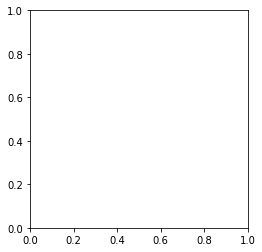

In [31]:
for mode in ["train", "valid", "test"]:
    bundle_size = 4
    if mode == "valid":
        bundle_size = bundle_size//2
    if mode == "test":
        bundle_size = bundle_size//4
    yolo_data('./test_folder/data/', mode, 640, bundle_size, 1)